## CNN Audio Classification based on Filter Banks for the Google Command Dataset.
## MobileNet

In [7]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as display
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
sys.path.append("..") # Adds higher directory to python modules path. This is important to load the libraries  in PROJECT_HOME/src/
import src.d01_load_data as ld #Library to load data and handle data.

#PROJECT_HOME = os.getcwd()+"/"
# NOTE that in this Jupyter notebook, the parent folder is the project home, not this!
PROJECT_HOME = os.path.dirname(os.getcwd())+"/"

SR_DATA="Speech Recognition/speech_commands_v0.01/" #Command dataset folder.
#SR_DATA="Speech Recognition/speech_commands_mini/" #Command dataset folder.

checkpointPath = PROJECT_HOME+"Speech Recognition/checkpoints/"
#commands = ["yes","one","left","bird","cat","dog"]
commands = ["yes","no"]
#commands = ["yes","one","left","bird"]
#commands = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']

dataSR = ld.DataLoader(PROJECT_HOME,SR_DATA,split_seconds=1.0)
dataSR.setCategories(commands)

dataSR = ld.DataLoader(PROJECT_HOME,SR_DATA,commands)
filesP,filesL = dataSR.getAllFilesPath()
dTrain,lTrain, dTest, lTest = dataSR.splitTrainingTest(filesP,filesL,splitSizeTest=0.30,shuffle=True) #Shuffle before getting the Training/Test

In [9]:
#GPU Available?
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Convert all the files into images:


In [29]:
# Execute:
# python create_img_dataset.py

In [96]:
#SR_DATA = "Speech Recognition/speech_commands_mini_IMG/" #Command dataset folder.
#SR_DATA = "Speech Recognition/speech_commands_minmed_IMG/" #Command dataset folder.
SR_DATA = "Speaker Identification/data_IMG/" #Command dataset folder.
#SR_DATA = "Speech Recognition/speech_commands_medium_IMG/" #Command dataset folder.
data_dir = PROJECT_HOME + SR_DATA
img_height = 40
img_width = 100
batch_size = 1

BATCH_SIZE = 100
IMG_HEIGHT = 40
IMG_WIDTH = 100

### Data Pipeline

In [102]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
data_path = pathlib.Path(PROJECT_HOME + SR_DATA)
image_count = len(list(data_path.glob('*/*.png')))
DATASET_SIZE = image_count
steps_per_epoch = int (DATASET_SIZE / BATCH_SIZE)
image_count 

20510

In [103]:
data_path

WindowsPath('C:/Users/ece_a/Desktop/Github/studentproject/Speaker Identification/data_IMG')

In [104]:
CLASS_NAMES = np.array([item.name for item in data_path.glob('*')])
CLASS_NAMES

array(['1272', '1462', '1673', '174', '1919', '1988', '1993', '2035',
       '2078', '2086', '2277', '2412', '2428', '251', '2803', '2902',
       '3000', '3081', '3170', '3536', '3576', '3752', '3853', '422',
       '5338', '5536', '5694', '5895', '6241', '6295', '6313', '6319',
       '6345', '652', '777', '7850', '7976', '8297', '84', '8842'],
      dtype='<U4')

In [105]:
import glob
#list_ds =  tf.data.Dataset.list_files(str(data_dir/'*/*'))

list_ds = tf.data.Dataset.list_files("C:/Users/ece_a/Desktop/Github/studentproject/Speaker Identification/data_IMG/*/*")
for f in list_ds.take(5):
  print(f.numpy())
#dataset = glob.glob("C:/Users/ece_a/Desktop/Github/studentproject/SPEECH~1/SPEECH~1.01_/*/*.png")
#dataset = tf.data.TextLineDataset(dataset)
#dataset

b'C:\\Users\\ece_a\\Desktop\\Github\\studentproject\\Speaker Identification\\data_IMG\\6319\\6319-275224-0011_5.png'
b'C:\\Users\\ece_a\\Desktop\\Github\\studentproject\\Speaker Identification\\data_IMG\\422\\422-122949-0001_8.png'
b'C:\\Users\\ece_a\\Desktop\\Github\\studentproject\\Speaker Identification\\data_IMG\\1988\\1988-148538-0011_9.png'
b'C:\\Users\\ece_a\\Desktop\\Github\\studentproject\\Speaker Identification\\data_IMG\\3536\\3536-8226-0016_4.png'
b'C:\\Users\\ece_a\\Desktop\\Github\\studentproject\\Speaker Identification\\data_IMG\\6241\\6241-61946-0013_6.png'


In [106]:
def get_label(file_path):
  parts = tf.strings.split(file_path, '\\')
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  img = tf.image.decode_png(img, channels=1) #color images
  img = tf.image.convert_image_dtype(img, tf.float32) 
   #convert unit8 tensor to floats in the [0,1]range
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#We will be using Dataset.map and num_parallel_calls is defined so that multiple images are loaded simultaneously.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds

<ParallelMapDataset shapes: ((100, 40, 1), (40,)), types: (tf.float32, tf.bool)>

In [107]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000,epochs=10):
    train_size = int(0.8 * DATASET_SIZE)
    val_size = int(0.1 * DATASET_SIZE)
    test_size = int(0.1 * DATASET_SIZE)

    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
            
    #ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    train_dataset = ds.take(train_size)
    test_dataset = ds.skip(train_size)
    val_dataset = test_dataset.skip(val_size)
    test_dataset = test_dataset.take(test_size)
    
    train_dataset = train_dataset.shuffle(buffer_size=shuffle_buffer_size,reshuffle_each_iteration=False)
    #train_dataset = train_dataset.repeat(epochs) #repeat forever  
    train_dataset = train_dataset.batch(BATCH_SIZE)  
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

    #test_dataset = test_dataset.repeat() #repeat forever  
    test_dataset = test_dataset.batch(BATCH_SIZE)  
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

    #val_dataset = val_dataset.repeat() #repeat forever  
    val_dataset = val_dataset.batch(BATCH_SIZE)  
    val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)    

    """
    ds = ds.repeat() #repeat forever  
    ds = ds.batch(BATCH_SIZE)  
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    """
    print(train_dataset)
    return train_dataset,test_dataset,val_dataset

In [108]:
train_ds, test_ds, val_ds = prepare_for_training(labeled_ds,cache=False, shuffle_buffer_size=1000,epochs=BATCH_SIZE)
image_batch, label_batch = next(iter(train_ds))
#image, mask = tf.data.Dataset.from_tensor_slices(list(train_ds))

<PrefetchDataset shapes: ((None, 100, 40, 1), (None, 40)), types: (tf.float32, tf.bool)>


##### checking the number of samples per class in training, validation, testing

ps: takes long, you can skip 

In [109]:
from collections import Counter
def count_labels(data):
    labels = []
    for x, y in data:
        for a in y: 
            count = 0
            for i in range (len(a)):
                count += 1
                if a[i] == True:
                    labels.append(count)
                            
    return len(labels), len(np.unique(labels)), Counter(labels)

images, labels, counted_labels = count_labels(train_ds)
print("train data: \n","number of images:", images, "number of labels:", labels)
print(counted_labels)
print("---------------")
images, labels, counted_labels= count_labels(val_ds)
print("val data: \n","number of images:", images, "number of labels:", labels)
print(counted_labels)
print("---------------")
images, labels, counted_labels = count_labels(test_ds)
print("test data: \n","number of images:", images, "number of labels:", labels)
print(counted_labels)

train data: 
 number of images: 16408 number of labels: 40
Counter({33: 432, 34: 430, 11: 428, 40: 425, 2: 425, 35: 424, 31: 421, 26: 419, 13: 416, 4: 415, 38: 415, 6: 415, 22: 415, 23: 415, 1: 414, 24: 413, 36: 413, 7: 411, 16: 411, 18: 410, 20: 410, 10: 409, 19: 409, 12: 408, 28: 408, 15: 407, 8: 406, 9: 405, 32: 405, 14: 404, 17: 402, 30: 400, 37: 400, 25: 400, 5: 400, 27: 399, 29: 398, 3: 396, 21: 394, 39: 381})
---------------
val data: 
 number of images: 2051 number of labels: 40
Counter({37: 70, 22: 69, 9: 65, 32: 61, 5: 59, 3: 59, 24: 58, 19: 57, 11: 57, 21: 56, 13: 56, 18: 55, 29: 54, 20: 54, 33: 53, 16: 53, 14: 51, 30: 51, 38: 50, 40: 50, 23: 50, 31: 50, 1: 50, 15: 49, 26: 49, 34: 49, 36: 49, 39: 48, 2: 47, 8: 47, 7: 47, 4: 46, 12: 46, 17: 44, 27: 42, 6: 42, 25: 41, 35: 40, 10: 39, 28: 38})
---------------
test data: 
 number of images: 2051 number of labels: 40
Counter({3: 64, 35: 63, 31: 63, 4: 61, 32: 59, 6: 58, 10: 57, 40: 57, 26: 57, 37: 56, 20: 55, 8: 55, 17: 55, 36: 5

In [13]:
#filecache_ds = prepare_for_training(labeled_ds, cache="./google2.tfcache")

In [14]:
#----Image Pipeline ENDS----

In [110]:
class_names = list(CLASS_NAMES)
class_names

['1272',
 '1462',
 '1673',
 '174',
 '1919',
 '1988',
 '1993',
 '2035',
 '2078',
 '2086',
 '2277',
 '2412',
 '2428',
 '251',
 '2803',
 '2902',
 '3000',
 '3081',
 '3170',
 '3536',
 '3576',
 '3752',
 '3853',
 '422',
 '5338',
 '5536',
 '5694',
 '5895',
 '6241',
 '6295',
 '6313',
 '6319',
 '6345',
 '652',
 '777',
 '7850',
 '7976',
 '8297',
 '84',
 '8842']

## MobileNet Architechture

In [111]:
# Source: https://colab.research.google.com/drive/1uUYdZk7EbOESRP7JFwHfsR7b9gUjxU75#scrollTo=O8YDQ9cJoQus&forceEdit=true&sandboxMode=true
# Note: You may use tf.keras.layers.DepthwiseConv2D but you won't be able to add BatchNorm and LeakyReLU layers.
# Hence, we are first performing depthwise convolutions and then a Conv2D with kernel size of 1.
def SeparableConv( x , num_filters , strides , alpha=1.0 ):
    x = tf.keras.layers.DepthwiseConv2D( kernel_size=3 , padding='same' )( x )
    x = tf.keras.layers.BatchNormalization(momentum=0.9997)( x )
    x = tf.keras.layers.Activation( 'relu' )( x )
    x = tf.keras.layers.Conv2D(int(np.floor( num_filters * alpha )) , kernel_size=( 1 , 1 ) , strides=strides , use_bias=False , padding='same' )( x )
    x = tf.keras.layers.BatchNormalization(momentum=0.9997)(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def Conv( x , num_filters , kernel_size , strides=1 , alpha=1 ):

    x = tf.keras.layers.Conv2D( int(np.floor( num_filters * alpha )) , kernel_size=kernel_size , strides=strides , use_bias=False , padding='same' )( x )
    x = tf.keras.layers.BatchNormalization( momentum=0.9997 )(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

# The number of classes are three.
num_classes = len(class_names)
#img_height = 40
#img_width = 100
FILTERS_1 = int(32) # Originally 32
FILTERS_2 = FILTERS_1*2 # 64
FILTERS_3 = FILTERS_2*2 # 128
FILTERS_4 = FILTERS_3*2 # 256
FILTERS_5 = FILTERS_4*2 # 512
FILTERS_6 = FILTERS_5*2 # 1024

# The shape of the input image.
#inputs = tf.keras.layers.Input( shape=( 300 , 300 , 3 ) )
inputs = tf.keras.layers.Input( shape=( 100 , 40 , 1 ) )
#inputs = tf.keras.layers.Input( shape=( img_height , img_width , 3 ) )

x = Conv( inputs , num_filters=int(FILTERS_1) , kernel_size=1 , strides=2 )
x = SeparableConv( x , num_filters=FILTERS_1 , strides=1 )
"""
x = Conv( x , num_filters=FILTERS_2 , kernel_size=1 )
x = SeparableConv( x , num_filters=FILTERS_2 , strides=2  )

x = Conv( x , num_filters=FILTERS_3 , kernel_size=1 )
x = SeparableConv( x , num_filters=FILTERS_3 , strides=1  )
x = Conv( x , num_filters=FILTERS_3 , kernel_size=1 )
x = SeparableConv( x , num_filters=FILTERS_3 , strides=2  )
x = Conv( x , num_filters=FILTERS_4 , kernel_size=1 )
x = SeparableConv( x , num_filters=FILTERS_4 , strides=1  )
x = Conv( x , num_filters=FILTERS_4 , kernel_size=1 )
x = SeparableConv( x , num_filters=FILTERS_4 , strides=2  )
x = Conv( x , num_filters=FILTERS_5 , kernel_size=1 )
"""
# You may uncomment the code below if you're machine could tolerate such heavy computation!
#for i in range( 5 ):
    #x = SeparableConv(x, num_filters=512 , strides=1 )
    #x = Conv(x, num_filters=512 , kernel_size=1 )
"""
x = SeparableConv(x, num_filters=FILTERS_5 , strides=2 )
x = Conv(x, num_filters=FILTERS_6 , kernel_size=1 )
"""
#x = tf.keras.layers.AveragePooling2D( pool_size=( 7 , 7 ) )( x )
x = tf.keras.layers.AveragePooling2D( pool_size=( 3 , 3 ) )( x )
x = tf.keras.layers.Flatten()( x )
x = tf.keras.layers.Dense( num_classes )( x )
outputs = tf.keras.layers.Activation( 'softmax' )( x )

model = tf.keras.models.Model( inputs , outputs )

# As we doing classification, we'll use categorical crossentropy and the RMSProp optimizer.
#model.compile( loss='categorical_crossentropy' , optimizer='rmsprop' , metrics=[ 'acc' ] )
model.compile( loss='categorical_crossentropy' , optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005) , metrics=[ 'acc' ] )



In [112]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 100, 40, 1)]      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 50, 20, 32)        32        
_________________________________________________________________
batch_normalization_61 (Batc (None, 50, 20, 32)        128       
_________________________________________________________________
activation_76 (Activation)   (None, 50, 20, 32)        0         
_________________________________________________________________
depthwise_conv2d_20 (Depthwi (None, 50, 20, 32)        320       
_________________________________________________________________
batch_normalization_62 (Batc (None, 50, 20, 32)        128       
_________________________________________________________________
activation_77 (Activation)   (None, 50, 20, 32)        0  

In [125]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard

In [126]:
#%tensorboard --logdir logs

In [113]:
epochs=10
#epochs = 2

In [114]:
checkpoint_path = "training_all/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
"""
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
"""
# Create a callback that saves the model's weights

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


#model.fit( train_ds , val_ds , epochs=5 , batch_size=25 )
#model.fit( train_X , train_Y , epochs=50 ,batch_size= 32, validation_data=(test_X, test_Y) ,callbacks=[cp_callback])
#model.fit( train_X , train_Y , epochs=50 ,batch_size= 32, validation_data=(test_X, test_Y) ,callbacks=[tensorboard_callback])
history = model.fit(
  train_ds,
  #batch_size= BATCH_SIZE,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[cp_callback]
)

Train for 165 steps, validate for 21 steps
Epoch 1/10
164/165 [============================>.] - ETA: 0s - loss: 3.0570 - acc: 0.2069
Epoch 00001: saving model to training_all/cp.ckpt
165/165 [==============================] - 44s 267ms/step - loss: 3.0540 - acc: 0.2070 - val_loss: 3.6881 - val_acc: 0.0219
Epoch 2/10
164/165 [============================>.] - ETA: 0s - loss: 1.8803 - acc: 0.5393- ETA: 0s - loss: 1.8847 - acc: 0.53
Epoch 00002: saving model to training_all/cp.ckpt
165/165 [==============================] - 44s 265ms/step - loss: 1.8779 - acc: 0.5394 - val_loss: 3.7047 - val_acc: 0.0258
Epoch 3/10
164/165 [============================>.] - ETA: 0s - loss: 1.2202 - acc: 0.7098
Epoch 00003: saving model to training_all/cp.ckpt
165/165 [==============================] - 46s 279ms/step - loss: 1.2189 - acc: 0.7098 - val_loss: 3.7350 - val_acc: 0.0219
Epoch 4/10
164/165 [============================>.] - ETA: 0s - loss: 0.8765 - acc: 0.7909
Epoch 00004: saving model to traini

KeyboardInterrupt: 

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.head()

In [ ]:
losses[['loss','val_loss']].plot()
plt.title('Loss for MobileNet Model \n Speaker Identification (SID)')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

losses[['acc','val_acc']].plot()
plt.title('Accuracy for MobileNet Model \n Speaker Idetification (SID)')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate the model

In [23]:
results = model.evaluate(test_ds)#batch_size=BATCH_SIZE)

print("test loss, test acc:", results)

250/250 [==============================] - 9s 35ms/step - loss: 3.2903 - acc: 0.5825
test loss, test acc: [3.290283727585236, 0.5825]


In [24]:
labels_test_truth = []
labels_test_pred = []
for x_test,y_test in test_ds:
    predictions = model.predict_on_batch(x_test)
    #print(predictions)
    predictions = tf.argmax(predictions, axis=-1)
    labels_test_pred += predictions.numpy().tolist() #Concatenate this batch predictions into a flat list.
    y_truth = tf.where(y_test)[:,1] #Take only the predictions
    labels_test_truth += y_truth.numpy().tolist() #Concatenate this batch ground truth.

Accuracy test:  59.3


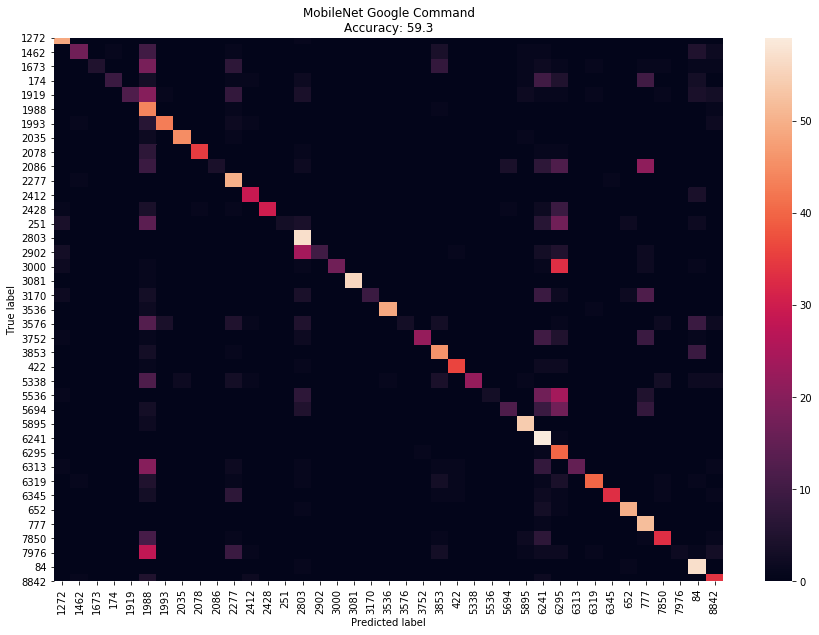

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def printConfusionMatrix(conf_mat,categories, acc,header="MobileNet Speaker Identification (SID)"):
    """Displays a colored plot of the confusion matrix"""
    cm_df = pd.DataFrame(conf_mat,
                        index = categories, 
                        columns = categories)
    plt.figure(figsize=(15,10))
    sns.heatmap(cm_df, annot=False)
    plt.title(header+"\nAccuracy: "+str(round(acc,2)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()        

accuracy_test = round(accuracy_score(labels_test_truth, labels_test_pred)*100,2)
conf_mat = confusion_matrix(labels_test_truth, labels_test_pred)
print("Accuracy test: ",accuracy_test)
printConfusionMatrix(conf_mat,CLASS_NAMES.tolist(),accuracy_test)

### Manual training #TO DO with Naveen

In [ ]:
#loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

In [ ]:
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []


for epoch in range(epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  #epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
  epoch_accuracy = tf.keras.metrics.CategoricalCrossentropy()

  # Training loop - using batches of 32
  #for x, y in train_ds:
  for _ in range(15):
    x,y =  next(iter(train_ds))
    # Optimize the model
    #x, y = x.float(), y.float()
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))
dis
  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  #if epoch % 5 == 0:
  print("Epoch {}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch, epoch_loss_avg.result(), epoch_accuracy.result()))

In [ ]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## References:
- https://medium.com/@hasithsura/audio-classification-d37a82d6715
- https://nextjournal.com/gkoehler/pytorch-mnist
- https://dzlab.github.io/timeseries/2018/11/25/LSTM-FCN-pytorch-part-1/